In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split

In [47]:
data = pd.read_csv('datasets/NO3_concentration.csv')
data.head()

Ord_Occ   Lat_Dec    Lon_Dec  Line   Sta  Depth  Pressure   Temp1   Temp2  \
0       71  34.38497 -122.24748  76.7  70.0    269   271.120  7.5485  7.5482   
1       80  34.63791 -123.37101  73.3  80.0    269   271.126  7.9818  7.9818   
2       25  32.65097 -119.48919  90.0  53.0    141   142.046  9.2561  9.2541   
3       70  34.05429 -122.94048  76.7  80.0    271   273.129  7.4577  7.4558   
4        5  32.84301 -117.52184  93.3  30.0    120   120.886  9.7380  9.7425   

   TempAve  ...    SaltB    OxB   OxBuM    NO3  NO2  NH4   PO4    SIL  \
0   7.5484  ...  34.0304  2.063   89.75  31.80  0.0  0.0  2.33  44.84   
1   7.9818  ...      NaN  2.256   98.56  30.77  0.0  0.0  2.23  39.43   
2   9.2551  ...  33.9126  2.562  111.49  25.81  0.0  NaN  2.01  29.28   
3   7.4568  ...  34.0239  1.989   86.53  32.47  0.0  0.0  2.37  46.22   
4   9.7403  ...  33.8635  2.726  118.65  24.14  0.0  0.0  1.89  25.39   

   BO2-SCO21  BO2-SCO22  
0     0.0176     0.0274  
1    -0.0073    -0.0020  
2     0.0133     0.0176  
3     0.0190     0.0245  
4    -0.0211    -0.0164  

[5 rows x 51 columns]

In [48]:
data.shape

(780, 51)

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780 entries, 0 to 779
Data columns (total 51 columns):
Ord_Occ              780 non-null int64
Lat_Dec              780 non-null float64
Lon_Dec              780 non-null float64
Line                 780 non-null float64
Sta                  780 non-null float64
Depth                780 non-null int64
Pressure             780 non-null float64
Temp1                780 non-null float64
Temp2                780 non-null float64
TempAve              780 non-null float64
Salt1                780 non-null float64
Salt1_Corr           780 non-null float64
Salt2                780 non-null float64
Salt2_Corr           780 non-null float64
SaltAve_Corr         780 non-null float64
Ox1                  780 non-null float64
Ox1_CruiseCorr       780 non-null float64
Ox1_StaCorr          780 non-null float64
Ox2                  780 non-null float64
Ox2_CruiseCorr       780 non-null float64
Ox2_StaCorr          780 non-null float64
OxAve_StaCorr    

## <center> Punto 0 </center>

Dividimos los datos para entrenamiento y para pruebas

In [50]:
data_train, data_test = train_test_split(data)
data_train.shape, data_test.shape

((585, 51), (195, 51))

## <center> Punto 1 </center>
Construir un modelo de regresión lineal de una sola variable para encontrar la respuesta del NO3 al voltaje (ISUS voltage).

In [82]:
import plotly.express as px
fig = px.scatter_3d(data, x='Lon_Dec', y='Lat_Dec', z='NO3',
                    color='ISUSV', title = "Respuesta del NO3 al ISUSV en su posición geográfica")
fig.show()

De entrada podemos observar que el NO3 tiene un comportamiento lineal con respecto a ISUSV, ya que mostrando los datos en us correspondiente ubicación geográfica se puede observar que a menor voltaje menor es la respuesta del NO3. Sin embargo tenemos que tener en cuenta que no se ha hecho ninguna limpieza a los datos ni se han aplicado técnicas para la corrección de los datos faltantes

-----
Vamos tomar sólo los datos que nos interesan

In [52]:
data_ISUSV_NO3_train = data_train[['ISUSV','NO3']]
data_ISUSV_NO3_test = data_test[['ISUSV','NO3']]
data_ISUSV_NO3_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 151 to 7
Data columns (total 2 columns):
ISUSV    585 non-null float64
NO3      456 non-null float64
dtypes: float64(2)
memory usage: 13.7 KB


Podemos ver que en __NO3__ sólo tenemos 457 datos mientras que en __ISUSV__ tenemos 585 que corresponde a la cantidad de registros en los datos crudos de entrenamiento. Tenemos datos completos para __ISUSV__ y datos faltantes para __NO3__

Observemos como están distribuidos los datos:

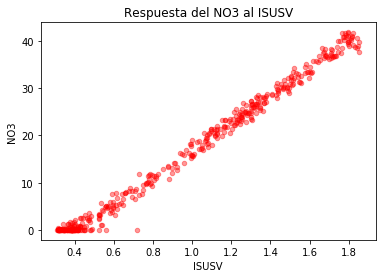

In [53]:
data_ISUSV_NO3_train.plot(kind = 'scatter',
                          x = 'ISUSV',
                          y = 'NO3',
                          title = 'Respuesta del NO3 al ISUSV',
                          alpha = 0.4,
                          c = 'red'
                         )

Se corrobora la linealidad observada en la primer imágen.

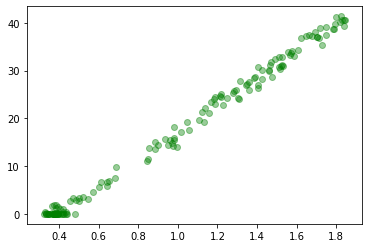

In [54]:
plt.scatter(data_ISUSV_NO3_test['ISUSV'].values, data_ISUSV_NO3_test['NO3'].values, c = 'g', alpha = 0.4)

In [55]:
data_ISUSV_NO3_train.describe()

ISUSV         NO3
count  585.000000  456.000000
mean     0.983085   16.334803
std      0.496254   14.013281
min      0.267800    0.000000
25%      0.440500    0.817500
50%      1.055400   16.995000
75%      1.366500   28.002500
max      1.853200   41.870000

Como tenemos datos faltanntes, debemos tratar estos datos de modo que no nos afecten la etapa de entrenamiento. Una de las metodologias es completar los datos faltantes con la moda o la media de cada caracteristica donde se presenten estos datos faltantes. En este caso, como ya sabemos que hay un comportamiento lineal creciente en __NO3__ con respecto a __ISUSV__, lo que causaríamos aplicando esta técnica es un ruido en los registros de __NO3__, ya que tenemos una média de 17.16. En otras palabras, se sabe que a mayor __ISUSV__ mayor respuesta de __NO3__, si aplicamos esta técnica, estaríamos diciendo que no importa el __ISUSV__, simpre hay una respuesta del __NO3__ de 17.16 en el 22.5% de las muestras (correspondientes a los datos faltantes)

### Eliminamos los registros con datos faltantes
Elegimos esta técnica, porque nos conserva una mejor tendencia en los datos. y así evitamos sobrecargar a nuestros datos con ruido innecesario. Debemos hacerlo tanto para datos de entrenamiento como para datos de pruebas.

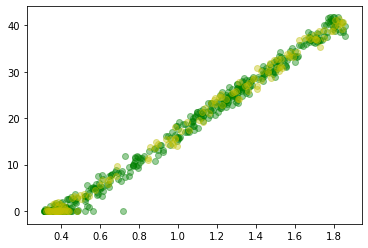

In [56]:
data_ISUSV_NO3_train = data_ISUSV_NO3_train[data_ISUSV_NO3_train['NO3'].isna() == False]
data_ISUSV_NO3_test = data_ISUSV_NO3_test[data_ISUSV_NO3_test['NO3'].isna() == False]
plt.scatter(data_ISUSV_NO3_train['ISUSV'].values, data_ISUSV_NO3_train['NO3'].values, alpha = 0.4, c = 'g')
plt.scatter(data_ISUSV_NO3_test['ISUSV'].values, data_ISUSV_NO3_test['NO3'].values, alpha = 0.4, c = 'y')

### Creando un modelo de Aprendizaje
Tenemos nuestros datos preparados para realizar un modelo de aprendizaje

In [57]:
X_train_1 = np.c_[data_ISUSV_NO3_train['ISUSV']]
y_train_1 = np.c_[data_ISUSV_NO3_train['NO3']]
X_test_1 = np.c_[data_ISUSV_NO3_test['ISUSV']]
y_test_1 = np.c_[data_ISUSV_NO3_test['NO3']]

model_1 = LinearRegression()
model_1.fit(X_train_1, y_train_1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [58]:
t1_m1 = model_1.coef_[0][0]
print('Coeficiente:', t1_m1)
t0_m1=model_1.intercept_[0]
print('Intercepto:', t0_m1)

Coeficiente: 28.025655384204292
Intercepto: -10.818744754080782


In [59]:
print(f"Score: {round(model_1.score(X_test_1, y_test_1), 3)}")

Score: 0.994


[0, 2, -1, 50]

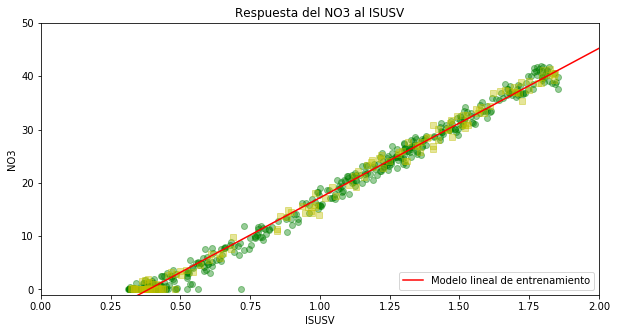

In [60]:
plt.figure(figsize=(10,5))
plt.title('Respuesta del NO3 al ISUSV')
plt.xlabel('ISUSV')
plt.ylabel('NO3')

plt.plot(X_train_1, y_train_1, 'go', alpha = 0.4)
plt.plot(X_test_1, y_test_1, 'ys', alpha = 0.4)

x=np.linspace(0, 2, len(X_train_1))

plt.plot(x, t0_m1 + t1_m1*x, 'r', label='Modelo lineal de entrenamiento')
plt.legend(loc='lower right')
plt.axis([0,2,-1,50])

Finalmente el modelo obtenido es el siguiente:
<center>$y = 28.05x -10.81$</center>

----

## <center> Punto 2 </center>

Construir un modelo de regresión lineal de dos variables para encontrar la respuesta del NO3 al voltaje (ISUS voltage) y al sensor de oxígeno Ox1.

In [61]:
data_ISUSV_Ox1_NO3_train = data_train[['ISUSV','Ox1','NO3']]
data_ISUSV_Ox1_NO3_test = data_test[['ISUSV','Ox1','NO3']]
data_ISUSV_Ox1_NO3_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 585 entries, 151 to 7
Data columns (total 3 columns):
ISUSV    585 non-null float64
Ox1      585 non-null float64
NO3      456 non-null float64
dtypes: float64(3)
memory usage: 18.3 KB


### Limpiamos los datos
Como en el caso anterior aplicamos la misma metodología de limpieza de datos

In [62]:
data_ISUSV_Ox1_NO3_train = data_ISUSV_Ox1_NO3_train[data_ISUSV_Ox1_NO3_train['NO3'].isna() == False]
data_ISUSV_Ox1_NO3_test = data_ISUSV_Ox1_NO3_test[data_ISUSV_Ox1_NO3_test['NO3'].isna() == False]

In [81]:
import plotly.express as px
fig = px.scatter_3d(data_ISUSV_Ox1_NO3_train, x='ISUSV', y='Ox1', z='NO3', title = 'Respuesta del NO3 al ISUSV y al Ox1',
                    color='NO3')
fig.show()

Se puede observar que tambien existe una respuesta lineal del __NO3__ al sensor de __Ox1__

### Creamos un modelos de Aprendizaje
En este caso debemos obtener una regresión lineal multivariada (2 variables)

In [64]:
X_train_2 = np.c_[data_ISUSV_Ox1_NO3_train[['ISUSV','Ox1']]]
y_train_2 = np.c_[data_ISUSV_Ox1_NO3_train['NO3']]

X_test_2 = np.c_[data_ISUSV_Ox1_NO3_test[['ISUSV','Ox1']]]
y_test_2 = np.c_[data_ISUSV_Ox1_NO3_test['NO3']]

model_2 = LinearRegression()
model_2.fit(X_train_2, y_train_2)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [65]:
print(f"Score: {round(model_2.score(X_test_2, y_test_2), 3)}")

Score: 0.993


In [66]:
t0_m2 = model_2.intercept_[0]
t1_m2 = model_2.coef_[0][0]
t2_m2 = model_2.coef_[0][1]
print(f"t0: {round(t0_m2,2)}\nt1: {round(t1_m2,2)}\nt2: {round(t2_m2,2)}")

t0: 1.02
t1: 21.99
t2: -1.66


Finalmente el modelo obtenido es el siguiente:
<center>$y = 23.06x_0 - 1.34x_1 - 1.13$</center>

----

## <center> Punto 3 </center>

Repetir el punto 1 usando penalización RIDGE y una grilla de búsqueda de diez hiperparámetros de penalización. Encuentre el hiperparámetro óptimo usando validación cruzada con 5-folds, 10-folds y leave-one-out (programando los algoritmos respectivos).

In [101]:
alpha_r_m1 = 0.5
ridge = Ridge(alpha=alpha_r_m1)
ridge.fit(X_train_1, y_train_1)
t0r_m1 = ridge.intercept_[0]
t1r_m1 = ridge.coef_[0][0]
print(f"t0r: {round(t0r_m1,2)}  ~  t0: {round(t0_m1,2)}")
print(f"t1r: {round(t1r_m1,2)}    ~  t1: {round(t1_m1,2)}")

t0r: -10.7  ~  t0: -10.82
t1r: 27.9    ~  t1: 28.03


[0, 2, -1, 50]

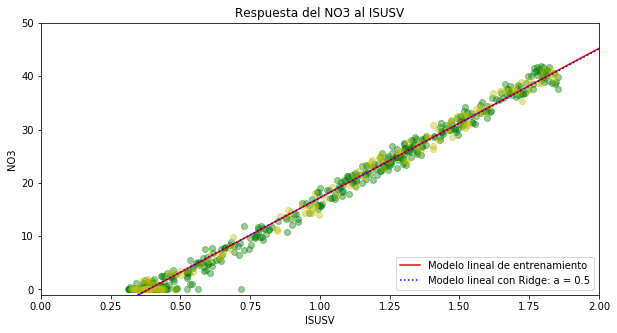

In [102]:
plt.figure(figsize=(10,5))
plt.title('Respuesta del NO3 al ISUSV')
plt.xlabel('ISUSV')
plt.ylabel('NO3')

plt.plot(X_train_1, y_train_1, 'go', alpha = 0.4)
plt.plot(X_test_1, y_test_1, 'yo', alpha = 0.4)

x=np.linspace(0, 2, len(X_train_1))

plt.plot(x, t0_m1 + t1_m1*x, 'r', label='Modelo lineal de entrenamiento')
plt.plot(x, t0r_m1 + t1r_m1*x, 'b:', label=f'Modelo lineal con Ridge: a = {alpha_r_m1}')
plt.legend(loc='lower right')
plt.axis([0,2,-1,50])